<div style="color:#8b1538; font-size:35px;">Benchmark of stairway plot 2</div>

In [3]:
import sei.analysis.stairway as stairway
import sei.files.files as f
import sei.graphics.plot as plot

> Load Data for stairway inference

In [4]:
data_decline = f.export_stairway_files(model="decline", fold=False)

In [8]:
french = False
lang="fr" if french else "en"  # set up lang for heatmap

<br>

# Stairway plot 2 inference

<div style="color: #8b1538; font-size: 32px">1. Log-likelihood ratio test</div><br>

Likelihood ratio test lrt assess the godness fit of two model. It's allow you to test wheter adding parameters to models significantly increase the likelihood the model.

1. Likelihood ratio test

\begin{equation}
\large{ lrt = -2*\frac{L0}{L1} }
\end{equation}

with L0 the likelihood of m0 and L1 the likelihood of m1 <br>

2. Log-likelihood ratio test

\begin{equation}
\large{ log(lrt) = 2 * (log_{10}L1 - log_{10}L0) }
\end{equation}

with $log_{10}L0$ the log-likelihood of m0 and $log_{10}L1$ the log-likelihood of m1

<br>

**Models**

* M0 a n0-parameter model - the model with less parameters

* M1 a n1-parameter model - the model with more parameters

with n0 < n1 (number of parameters)

<br>

**Hypothesis**

* H0 the null hypothesis - adding the parameter(s) does not significantly increase the likelihood of the model

* H1 the alternative hypothesis - adding the parameter(s) significantly increase the likelihood of the model

<br>

**Decision rule**

* If p-value >= $\alpha$ then the test is insignificant and do not reject of H0

* If p-value < $\alpha$ then the test is significant and reject of H0

with $\alpha = 0.05$

<br>

**Degrees of freedom**

The difference in the number of parameters between M0 and M1, i.e. n1 - n0

<br>

<div style="font-size: 18px; font-weight: bold">Log-likelihood ratio test between M0 and M1</div></br>

In [9]:
ll_m1_decline = stairway.stairway_ll_test(data_decline, 'm1')

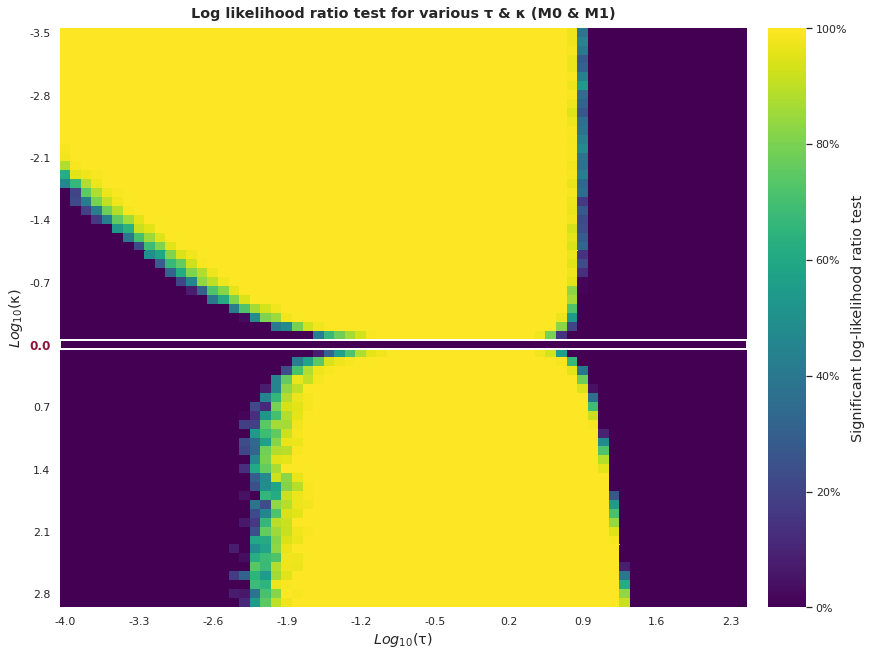

In [10]:
if lang == 'fr':
    title = "Test du rapport de vraisemblance entre M0 et M1 pour différents τ & κ"
    cbar = "Test du rapport de vraisemblance significatif"
else:
    title = "Log likelihood ratio test for various τ & κ (M0 & M1)"
    cbar = "Significant log-likelihood ratio test"

plot.plot_heatmap(data=ll_m1_decline, title=title, cbar=cbar, filout='./Figures/Stairway/Heatmap/heatmap_lrt(M0-M1).png', lrt=True)

<br>

<div style="font-size: 18px; font-weight: bold">Log-likelihood ratio test between M1 and the final model</div></br>

In [11]:
ll_final_decline = stairway.stairway_ll_test(data_decline, 'final')

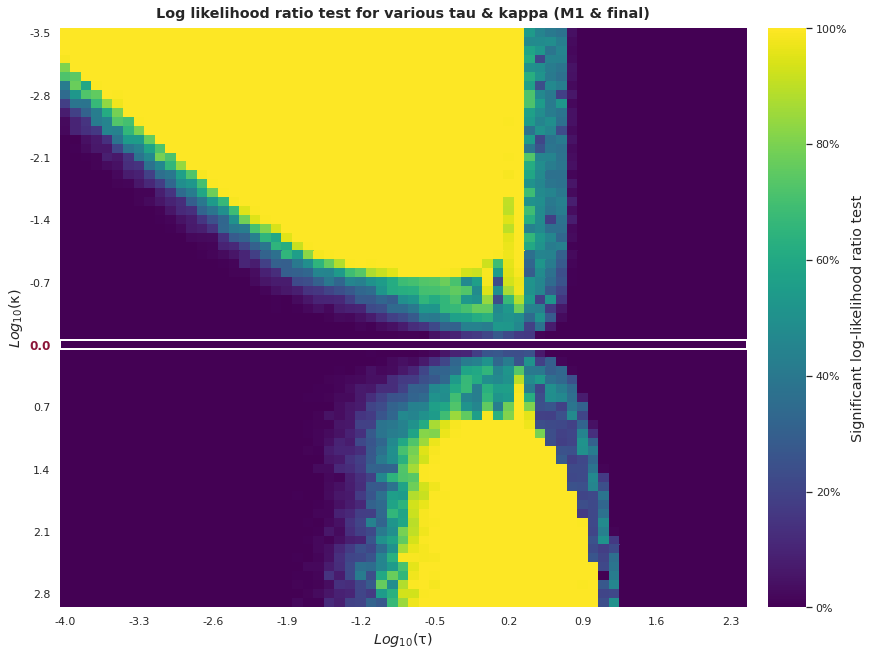

In [12]:
if lang == 'fr':
    title = "Test du rapport de vraisemblance entre M1 et modèle final pour différents τ & κ"
    cbar = "Test du rapport de vraisemblance significatif"
else:
    title = "Log likelihood ratio test for various tau & kappa (M1 & final)"
    cbar = "Significant log-likelihood ratio test"

plot.plot_heatmap(data=ll_final_decline, title=title, cbar=cbar, filout="./Figures/Stairway/Heatmap/heatmap_lrt(M1-final).png", lrt=True)

<br>

<div style="font-size: 18px; font-weight: bold">Dimensional difference between the final model and M1</div></br>

M1 is a model of 2 dimensions, i.e. a model of one past demographic event.

In [13]:
dimension_decline = stairway.stairway_dimension_comparaison(data_decline)

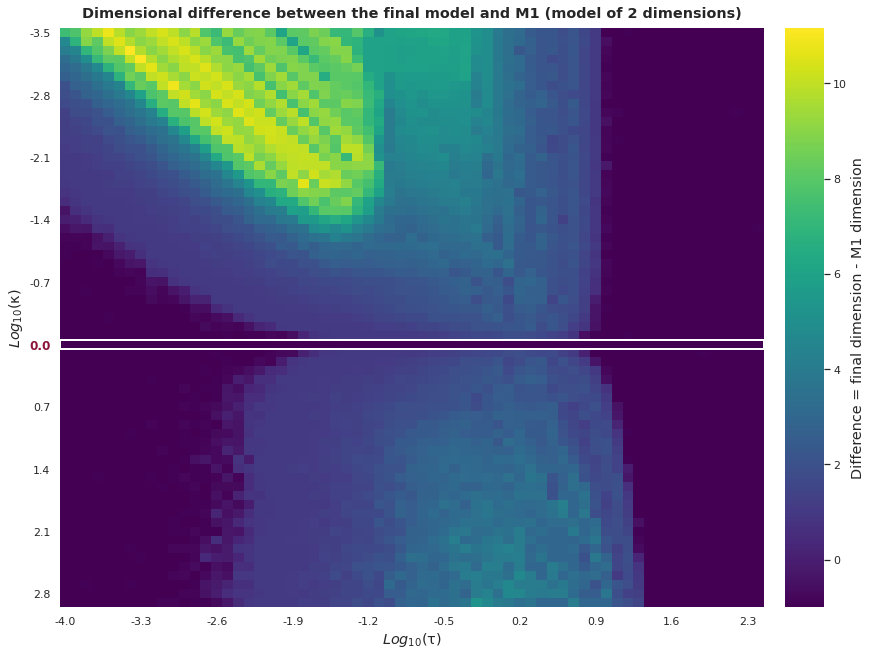

In [17]:
if lang == 'fr':
    title = "Différence de dimensions entre le modèle M1 et le modèle final"
    cbar = "Différence = dimension final - dimension M1"
else:
    title = "Dimensional difference between the final model and M1 (model of 2 dimensions)"
    cbar = "Difference = final dimension - M1 dimension"

plot.plot_heatmap(data=dimension_decline, title=title, cbar=cbar, filout="./Figures/Stairway/Heatmap/heatmap_dimension.png")

<div style="font-size: 18px; font-weight: bold">Detecting past demographic event</div></br>

In [18]:
ne_decline = stairway.stairway_distance_ne(data_decline)

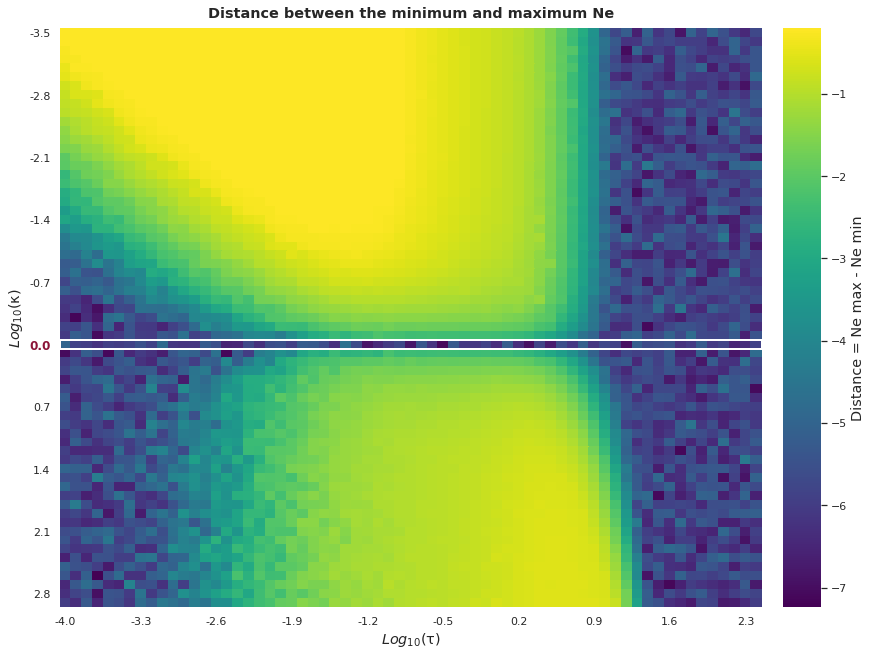

In [16]:
if lang == 'fr':
    title = "Distance entre le Ne min et max"
    cbar = "Distance = Ne max - Ne min"
else:
    title = "Distance between the minimum and maximum Ne"
    cbar = "Distance = Ne max - Ne min"

plot.plot_heatmap(data=ne_decline, title=title, cbar=cbar, filout="./Figures/Stairway/Heatmap/heatmap_ne.png")

<div style="font-size: 18px; font-weight: bold">Evaluation of estimated parameters</div></br>

> Tau

In [21]:
tau_decline = stairway.stairway_distance_param(data_decline, parameter='tau')

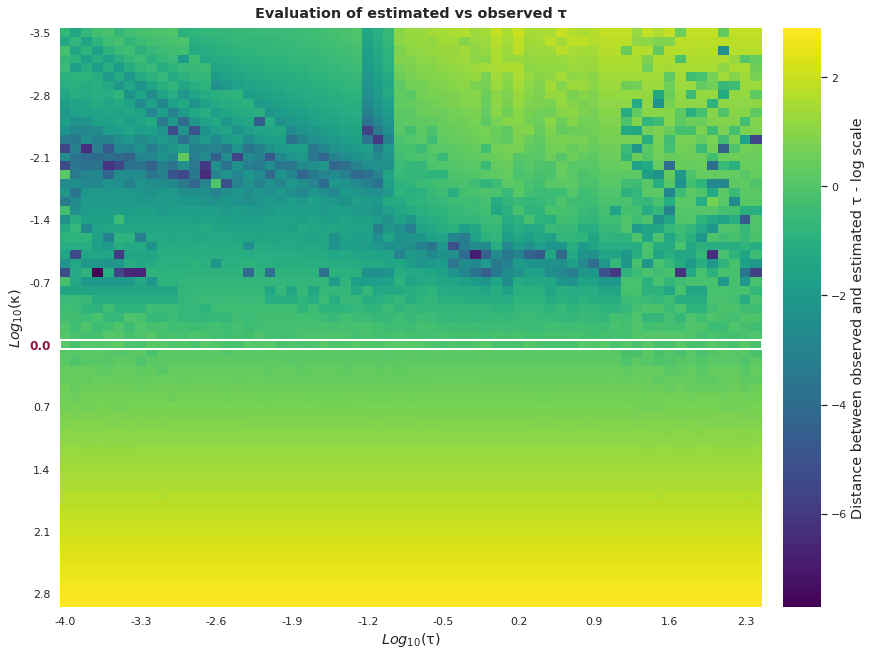

In [22]:
if lang == 'fr':
    title = "Evaluations des τ estimés par rapport à ceux observés"
    cbar = "Distance entre les τ observés estimés - échelle logarithmique"
else:
    title = "Evaluation of estimated vs observed τ"
    cbar = "Distance between observed and estimated τ - log scale"

plot.plot_heatmap(data=tau_decline, title=title, cbar=cbar, filout="./Figures/Stairway/Heatmap/heatmap_tau.png")

> Kappa

In [19]:
kappa_decline = stairway.stairway_distance_param(data_decline, parameter='kappa')

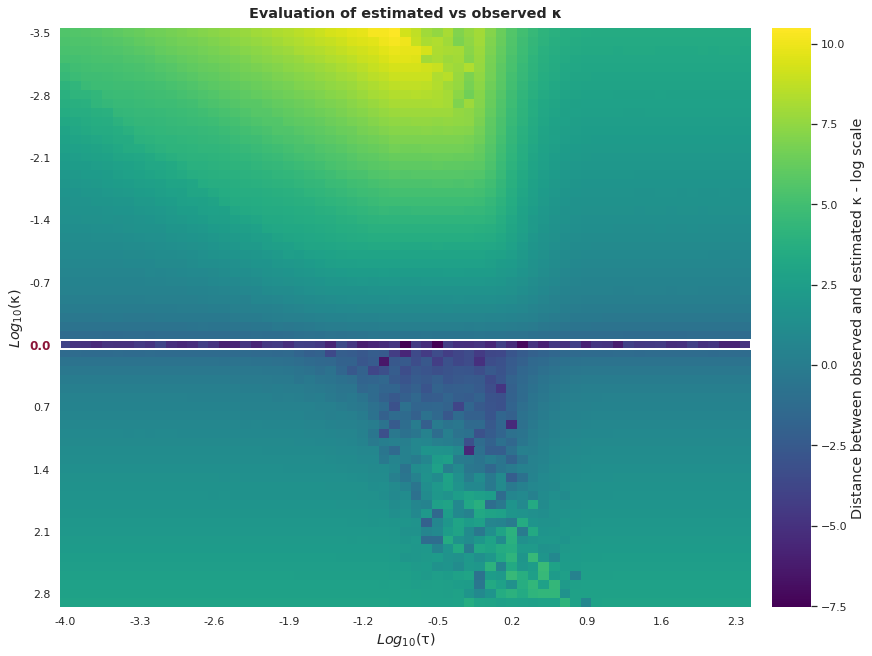

In [20]:
if lang == 'fr':
    title = "Evaluations des κ estimés par rapport à ceux observés"
    cbar = "Distance entre les κ observés estimés - échelle logarithmique"
else:
    title = "Evaluation of estimated vs observed κ"
    cbar = "Distance between observed and estimated κ - log scale"

plot.plot_heatmap(data=kappa_decline, title=title, cbar=cbar, filout="./Figures/Stairway/Heatmap/heatmap_kappa.png")

<br>

### Constan population

Stairway plot inference for some constant population with Ne = 1, Ne = 2, Ne = 10 & Ne = 100.

In [2]:
def sfs_cst_pop():
    # DataFrame
    data = pd.DataFrame(columns=['Parameters', 'SNPs', 'SFS observed'])
    
    # Parameters for the simulation
    params = {"sample_size": 20, "Ne": 0, "rcb_rate": 2e-2, "mu": 2e-2, "length": 1e5}
    
    for ne in [1, 2, 10]:
        params['Ne'] = ne
        
        # Constant scenario
        sfs = ms.msprime_simulation(model=ms.constant_model, params=params, debug=True)
        
        dico = {'Parameters': params.copy(), 'SNPs': [np.mean(sfs)], 'SFS observed': [sfs]}
        data = data.append(dico, ignore_index=True)
        
    return data


def inference_cst_pop(generate=False):
    if generate:
        data = sfs_cst_pop()
        data.to_json("./Data/Msprime/cst/SFS-cst")
    else:
        data = pd.read_json("./Data/Msprime/cst/SFS-cst")
        
    return data

In [3]:
simulation = inference_cst_pop(generate=False)

In [4]:
simulation

,Parameters,SNPs,SFS observed
0,"{'sample_size': 20, 'Ne': 1, 'rcb_rate': 0.02,...",[1462.1578947368],"[[7471, 4056, 2625, 1957, 1514, 1294, 1165, 10..."
1,"{'sample_size': 20, 'Ne': 2, 'rcb_rate': 0.02,...",[2986.1052631579],"[[15996, 8189, 5265, 4084, 3094, 2723, 2093, 2..."
2,"{'sample_size': 20, 'Ne': 10, 'rcb_rate': 0.02...",[15017.8421052632],"[[80377, 40178, 26825, 20229, 16309, 13161, 11..."


In [5]:
%%capture

for _, row in simulation.iterrows():
    sei.save_stairway_inference(row, 'cst')
    break

<br>

In [6]:
data = pd.read_json("./Data/Msprime/decline/SFS_decline-all")

Text(0.5, 1.0, "{'Tau': 0.0006309573, 'Kappa': 794.3282347243}")

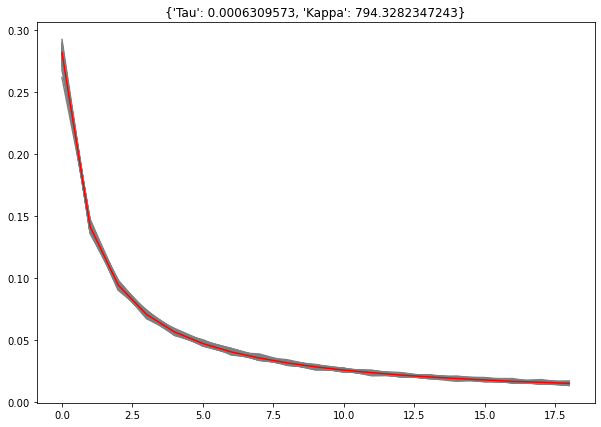

In [75]:
sfs = data.iloc[0]['SFS observed']
new = np.array([sum(spectrum) for spectrum in zip(*sfs)]) / len(sfs)

plt.figure(figsize=(10, 7))

for spectrum in sfs:
    plt.plot([ele/sum(spectrum) for ele in spectrum], color="grey")
plt.plot([ele/sum(new) for ele in new], color="red")
plt.title({k: v for k, v in data.iloc[0]['Parameters'].items() if k in ['Tau', 'Kappa']})